In [1]:
import numpy as np
import pickle
import sys
import folium
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from typing import List, Tuple
from branca.element import Figure
from collections import defaultdict
sys.path.append("..")

from utils import get_dvc_dir
from src.models.data import CropDataset
from src.ETL.dataset import DataDir
from src.datasets_labeled import labeled_datasets

In [2]:
features_dir = get_dvc_dir("features")

In [3]:
def load_features(feature_folder, subset):
    pickle_files_dir = features_dir / feature_folder / subset
    pickle_files = list(pickle_files_dir.glob(f"*.pkl"))
    
    instances = []
    for target_file in tqdm(pickle_files):
        with target_file.open("rb") as f:
            instances.append(pickle.load(f))
            
    return instances

In [4]:
def crop_percentage(features):
    total = len(features)
    if total == 0:
        return
    crop = len([feature for feature in features if feature.crop_probability > 0.5])
    non_crop = total - crop
    return f"Crop: {crop} ({crop / total:.1%}),\nNon-crop {non_crop} ({non_crop / total:.1%})"

In [5]:
def bands_mean(features):
    crop_bands = []
    non_crop_bands = []
    for feature in features:
        bands = feature.labelled_array.mean(axis=0)
        if feature.crop_probability > 0.5:
            crop_bands.append(bands)
        else:
            non_crop_bands.append(bands)

    crop_bands_mean = np.array(crop_bands).mean(axis=0)
    non_crop_bands_mean = np.array(non_crop_bands).mean(axis=0)
    return crop_bands_mean, non_crop_bands_mean

  0%|          | 0/6914 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/2574 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/4452 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/landcover-mapping/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':


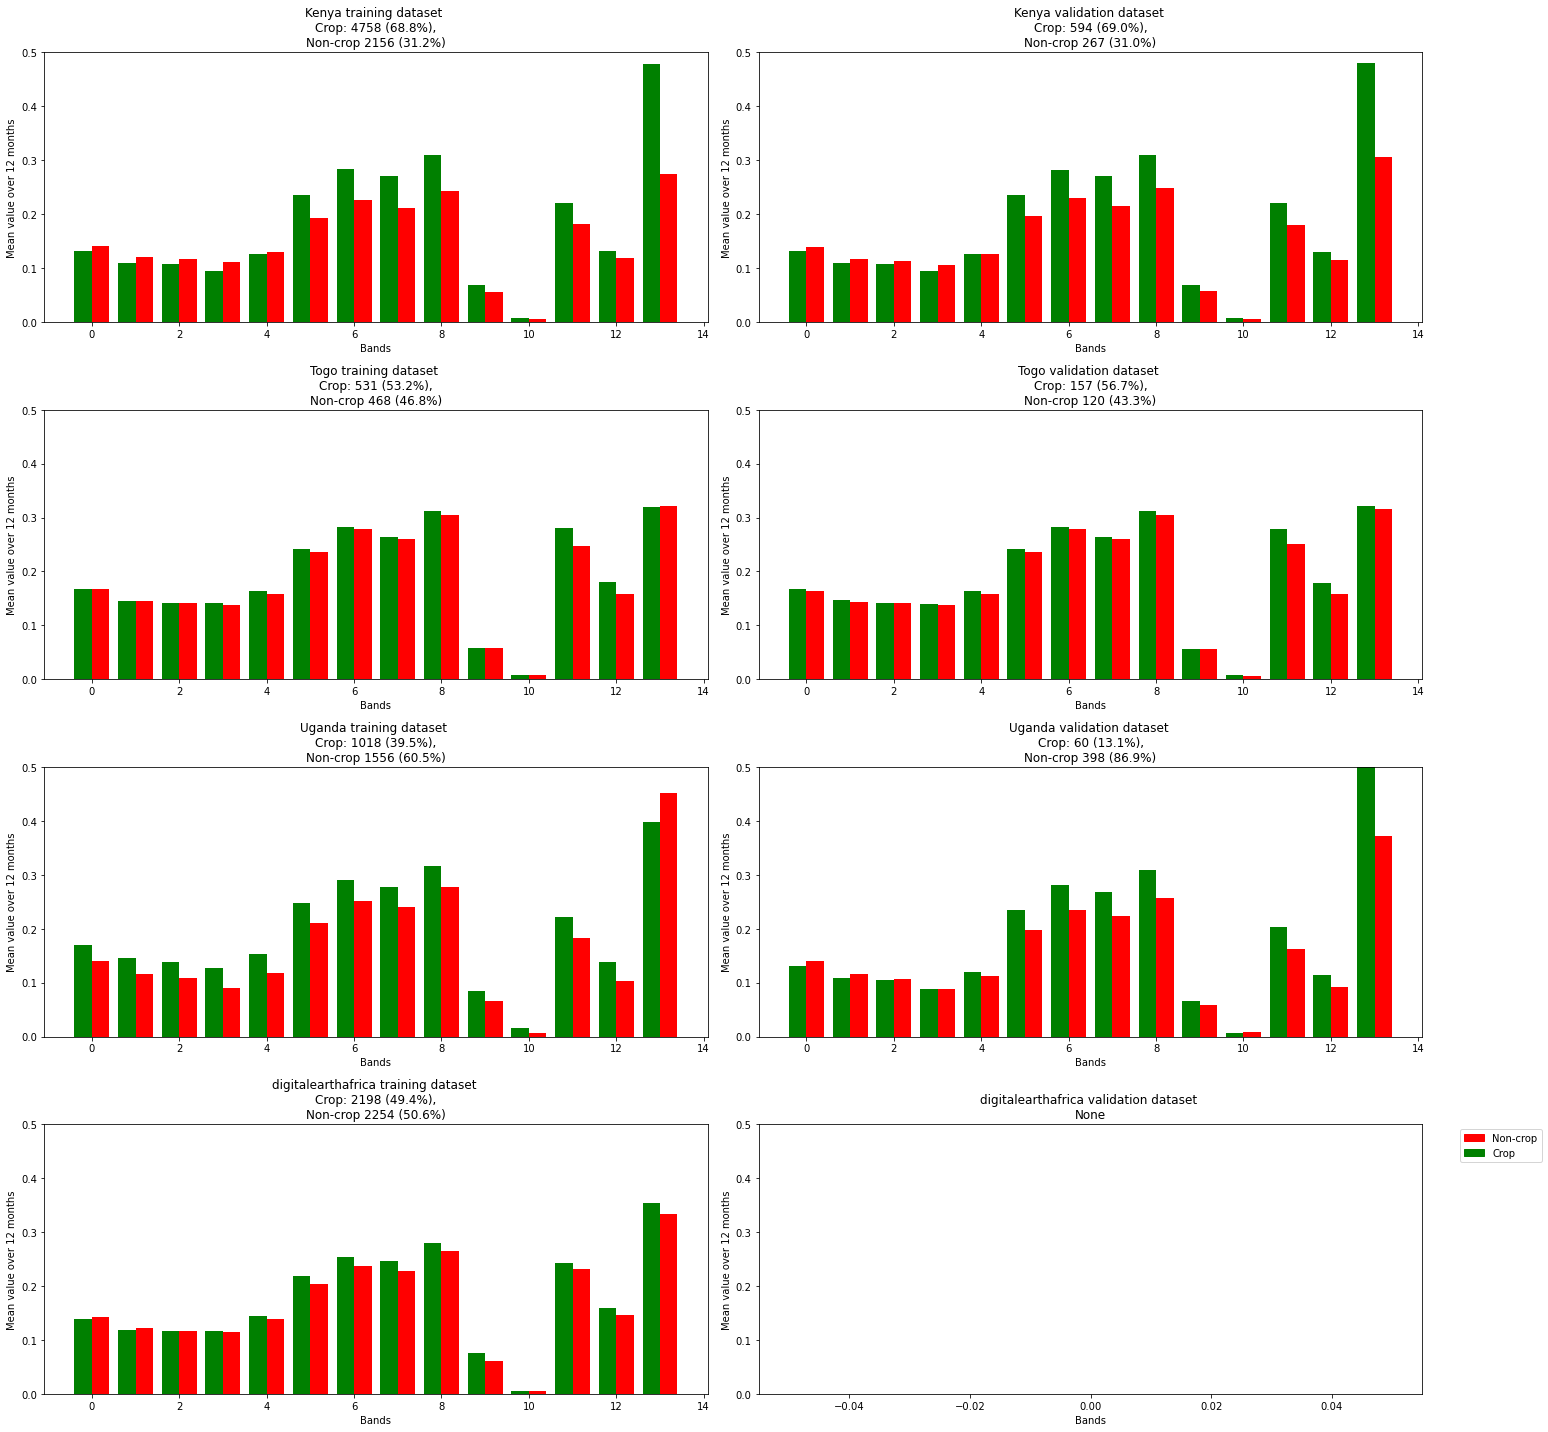

In [6]:
bands = np.arange(14)
datasets = ["Kenya", "Togo", "Uganda", "digitalearthafrica"]
subsets = ["training", "validation"]


nrows = len(datasets)
ncols = len(subsets)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols,5*nrows))

for i, dataset in enumerate(datasets):
    for j, subset in enumerate(subsets):
        features = load_features(dataset, subset)
        crop_pct = crop_percentage(features)
        crop, non_crop = bands_mean(features)
        
        if len(datasets) == 1 and len(subsets) == 1:
            ax = axes
        elif len(datasets) == 1:
            ax = axes[j]
        elif len(subsets) == 1:
            ax = axes[i]
        else:
            ax = axes[i][j]
            
        ax.bar(bands-0.2, crop, width=0.4, color='g', align='center')
        ax.bar(bands+0.2, non_crop, width=0.4, color='r', align='center')
        ax.set_xlabel("Bands")
        ax.set_ylabel("Mean value over 12 months")
        ax.set_title(f"{dataset} {subset} dataset \n{crop_pct}")
        ax.set_ylim([0, 0.5])
plt.tight_layout()

red_patch = mpatches.Patch(color='red', label='Non-crop')
green_patch = mpatches.Patch(color='green', label='Crop')
plt.legend(handles=[red_patch, green_patch], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# VIsualize Data

In [95]:
map_box_token = "pk.eyJ1IjoiaXp2b25rb3YiLCJhIjoiY2t0YXU4bzU0MXB0djJ3bzg1em90amN5aSJ9.f9qS4VASIK38tQpPVyFLWw"

In [96]:
esri_kwargs = {
    "tiles": "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    "attr": "Esri",
    "name": "Esri Satellite",
}

mapbox_kwargs = {
    "tiles": 'https://api.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token='+map_box_token,
    "attr": 'mapbox.com',
    "name": "Mapbox"
}

def plot_map(
    color_bboxes: List[Tuple[str, List[Tuple[float, float]]]] = None, 
    color_markers: List[Tuple[str, List[Tuple[float, float]]]] = None, 
    zoom_start: int = 15, 
    width: int = 500, 
    height: int = 200,
    map_kwargs=esri_kwargs
) -> Figure:
    if color_bboxes:
        # First bbox is used as center
        first_points = color_bboxes[0][1]
        
    elif color_markers:
        # First point is used as center
        first_points = color_markers[0][1]
        
    else:
        raise ValueError("At least one of color_bboxes or color_markers must be set")
        
    center = list(np.array([p[i] for p in first_points]).mean() for i in [0,1])

    m = folium.Map(location=center, zoom_start=zoom_start, **map_kwargs)
    
    if color_bboxes:
        for color, bbox in color_bboxes:
            folium.Rectangle(bounds=bbox, color=color).add_to(m)
        
    if color_markers:
        feature_group = folium.FeatureGroup('markers')
        for color, markers in color_markers:
            for marker in markers:
                folium.Marker(location=marker, icon=folium.Icon(color=color)).add_to(feature_group)
        feature_group.add_to(m)

    fig = Figure(width=width, height=height)
    return fig.add_child(m)

def bbox_from_corners(x_min: float, x_max: float, y_min: float, y_max: float) -> List[Tuple[float, float]]:
    points = [(y_min, x_min), (y_min, x_max), (y_max, x_min), (y_max, x_max)]
    return points

In [158]:
labels = pd.concat([pd.read_csv(d.get_path(DataDir.LABELS_PATH)) for d in labeled_datasets])

In [162]:
def get_source(inst):
    lon, lat = inst.label_lon, inst.label_lat
    src = labels[(labels["lon"] == inst.label_lon) & (labels["lat"] == inst.label_lat)]["source"].iloc[0]
    return src

In [163]:
crop = defaultdict(list)
non_crop = defaultdict(list)
srcs = set()
for t in train:
    src = get_source(t)
    t.src = src
    if t.crop_probability > 0.5:
        crop[src].append(t)
    else:
        non_crop[src].append(t)
    srcs.add(src)

In [164]:
for src in srcs:
    print(src)
    print(f"Crop: {len(crop[src])}")
    print(f"Non-crop: {len(non_crop[src])}")
    print()

ug_pre_season_assessment_2021_08_11_18_15_27_323695.csv
Crop: 384
Non-crop: 0

ug_in_season_monitoring_2021_08_11_17_50_46_428737.csv,ug_end_of_season_assessment_2021_08_11_17_47_53_813908.csv
Crop: 1
Non-crop: 0

WDPA_WDOECM_Aug2021_Public_UGA_shp_2.zip
Crop: 0
Non-crop: 508

ug_in_season_monitoring_2021_08_11_17_50_46_428737.csv
Crop: 463
Non-crop: 0

WDPA_WDOECM_Aug2021_Public_UGA_shp_0.zip
Crop: 0
Non-crop: 899

ug_end_of_season_assessment_2021_08_11_17_47_53_813908.csv,ug_pre_season_assessment_2021_08_11_18_15_27_323695.csv
Crop: 4
Non-crop: 0

ug_end_of_season_assessment_2021_08_11_17_47_53_813908.csv
Crop: 150
Non-crop: 0

ceo-2019-Uganda-Cropland-(RCMRD--Set-1)-sample-data-2021-06-11.csv,ceo-2019-Uganda-Cropland-(RCMRD--Set-2)-sample-data-2021-06-11.csv
Crop: 9
Non-crop: 101

ug_in_season_monitoring_2021_08_11_17_50_46_428737.csv,ug_pre_season_assessment_2021_08_11_18_15_27_323695.csv
Crop: 7
Non-crop: 0

WDPA_WDOECM_Aug2021_Public_UGA_shp_1.zip
Crop: 0
Non-crop: 48



In [165]:
ug_train = [t for t in train if t.src.startswith("ug_")]

In [167]:
len(train)

2574

In [170]:
bboxes = []
bbox_size = 0.0001
for t in ug_train:
    point = (t.label_lat, t.label_lon)
    max_lon = t.label_lon + bbox_size
    max_lat = t.label_lat + bbox_size
    min_lon = t.label_lon - bbox_size
    min_lat = t.label_lat - bbox_size
    bbox = bbox_from_corners(min_lon, max_lon, min_lat, max_lat)
    if t.crop_probability > 0.5:
        color = "yellow"
    else:
        color = "red"
    bboxes.append((color, bbox))

In [171]:
plot_map(color_bboxes=bboxes, width=800, height=800, zoom_start=7, map_kwargs=mapbox_kwargs)

In [ ]:
i = 17

In [213]:
i += 1
plot_map(color_bboxes=[bboxes[i]], zoom_start=18, width=600, height=500, map_kwargs=mapbox_kwargs)

In [211]:
li = list(range(10))

In [177]:
li[0]

0

# Uganda baseline model

In [14]:
train, val = [load_features("Uganda", subset) for subset in ["training", "validation"]]

  0%|          | 0/2574 [00:00<?, ?it/s]

  0%|          | 0/458 [00:00<?, ?it/s]

In [44]:
def generate_X_y(data):
    y = [1.0 if d.crop_probability > 0.5 else 0 for d in data]
    X = [d.labelled_array for d in data]
    return X, y

In [45]:
X_train, y_train = generate_X_y(train)
X_val, y_val = generate_X_y(val)

In [ ]:
# UG in season monitoring data